### Setup

In [1]:
##%load_ext lab_black
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import pandas as pd
import data.background as utils

utils.setWidgetTextSize(2)

In [2]:
filename = "data/liste.de.mots.francais.frgut.csv"

word_dict = utils.import_data(filename)
word_dict = utils.delete_useless_word_in_pd(word_dict)

utils.getPredictions = utils.getPredictionsFromDict(word_dict)

print("Nombre de mots dans le dictionnaire: ", len(word_dict))

TestWord = "abouhcemsnr"

IntProgress(value=0, description='Loading:', max=4, style=ProgressStyle(bar_color='blue'))

Nombre de mots dans le dictionnaire:  336437


### Distance de Levenstein

Cet algorithme permet de calculer la distance entre deux mots.
Il n'as que 3 opérations de base qui sont:
* l'ajout
* la supperssion
* la substitution

On construit un tableau avec ces règles et pour chaque opérartions on ajoute 1 a la case.

<div>
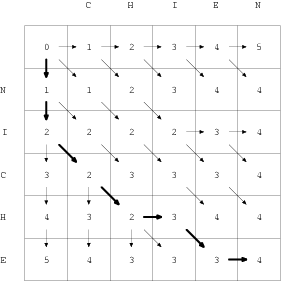
</div>

In [3]:
def DistanceDeLevenshtein(c1, show_table=False):

    width = len(c1) + 1

    def funct(c2):
        D = []
        height = len(c2) + 1
        for i in range(0, height):
            D.append([0] * width)
            D[i][0] = i
        for j in range(1, width):
            D[0][j] = j

        for i in range(1, height):
            for j in range(1, width):
                coutSubtitution = 1
                if c1[j - 1] == c2[i - 1]:
                    coutSubtitution = 0
                D[i][j] = min(
                    D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + coutSubtitution
                )
        if show_table:
            utils.showLevensteinTable("Tableau de Levenshtein", c1, c2, D)

        return D[-1][-1]

    return funct

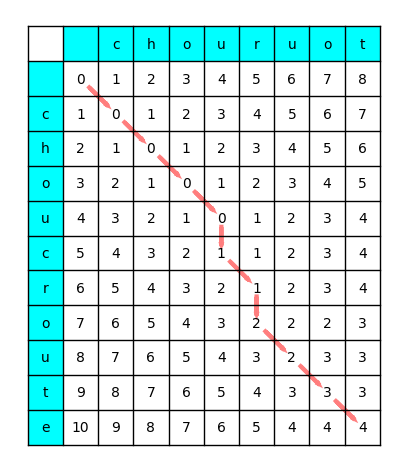

4

In [4]:
DistanceDeLevenshtein("chouruot", show_table=True)("choucroute")

In [5]:
pred, time_elapsed = utils.getPredictions(DistanceDeLevenshtein, TestWord, TestWord[:2])
print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeLevenshtein.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeLevenshtein as mis 0.777906 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
851  abouchement         4
936   aboutement         4
562    aboiement         5


### Distance Damerau-Levenstein

Cet algorithme reprend les mêmes opérations que celui de levenstein mais implémente aussi inversion entre deux lettres cote à cote.
Toutes ces opérations correspondent a 80% des fautes d'orthographes humaines.

In [6]:
def DistanceDeDamerauLevenshtein(c1, show_table=False):

    width = len(c1) + 1

    def funct(c2):
        D = []
        height = len(c2) + 1
        for i in range(0, height):
            D.append([0] * width)
            D[i][0] = i
        for j in range(1, width):
            D[0][j] = j

        for i in range(1, height):
            for j in range(1, width):
                coutSubtitution = 1
                if c1[j - 1] == c2[i - 1]:
                    coutSubtitution = 0
                D[i][j] = min(
                    D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + coutSubtitution
                )
                if (
                    i > 0
                    and j > 0
                    and c1[j - 1] == c2[i - 2]
                    and c1[j - 2] == c2[i - 1]
                ):
                    D[i][j] = min(D[i][j], D[i - 2][j - 2] + coutSubtitution)
        if show_table:
            utils.showLevensteinTable("Tableau de Damerau-Levenshtein", c1, c2, D)
        return D[-1][-1]

    return funct

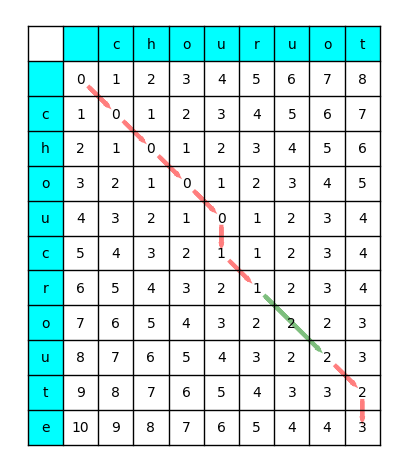

3

In [7]:
DistanceDeDamerauLevenshtein("chouruot", show_table=True)("choucroute")

In [8]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeDamerauLevenshtein, TestWord, TestWord[:2]
)

print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeDamerauLevenshtein.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeDamerauLevenshtein as mis 0.925695 secondes pour s'executer
Prediction for word:  abouhcemsnr
            ortho  affinity
851   abouchement         3
852  abouchements         4
853     abouchent         4


### Distance de Jaro


In [9]:
def DistanceDeJaro(c1, show_table=False):
    len_c1 = len(c1)
    def funct(c2):
        len_c2 = len(c2)
        if c1 == c2:
            return 1
        limit = int(max(len_c1, len_c2) / 2) - 1
        match = 0 
        c1_match = [0] * len_c1
        c2_match = [0] * len_c2
        for i in range(len_c1):
            for j in range(max(0, i - limit), min(len_c2, i + limit + 1)):
                if c1[i] == c2[j] and not c2_match[j]:
                    c1_match[i], c2_match[j] = 1, 1
                    match += 1
                    break
                    
        if show_table:
            utils.showJaroTable("Table de Jaro", c1, c2)
        if match == 0:
            return 0
        t = 0
        point = 0
        for i in range(len_c1):
            if c1_match[i]:
                while not c2_match[point]:
                    point += 1
                if c1[i] != c2[point]:
                    t += 1
                point += 1
        t /= 2
        return ((match / float(len_c1))+ (match / float(len_c2))+ ((match - t) / float(match))) / 3.0
    return funct

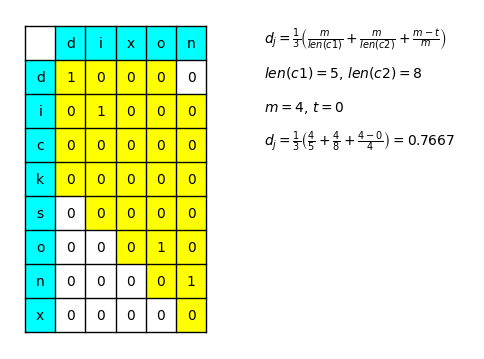

0.7666666666666666

In [19]:
DistanceDeJaro("dixon", show_table=True)("dicksonx")

In [11]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeJaro, TestWord, TestWord[:2], mofier_funct=lambda x: 1 - x
)

print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeJaro.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeJaro as mis 0.652326 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
865  aboucherons  0.127273
854     aboucher  0.132576
867     abouches  0.132576


### Distance de Jaro-Winker


In [12]:
def DistanceDeJaroWinkler(c1, threshold=0.7, p=0.1, show_table=False):
    fDistanceDeJaro = DistanceDeJaro(c1)

    def funct(c2):
        dj = fDistanceDeJaro(c2)

        l = 0
        pos = 0
        if dj > threshold:
            for i in range(min(len(c1), len(c2))):
                if c1[l] != c2[l]:
                    break
                if l >= 4:
                    break
                l += 1

        if show_table:
            utils.showJaroTable(
                "Table de Jaro-Winkler",
                c1,
                c2,
                Winkler=True,
                p=p,
                threshold=threshold,
                l=l,
            )

        return dj + (l * p * (1 - dj))

    return funct

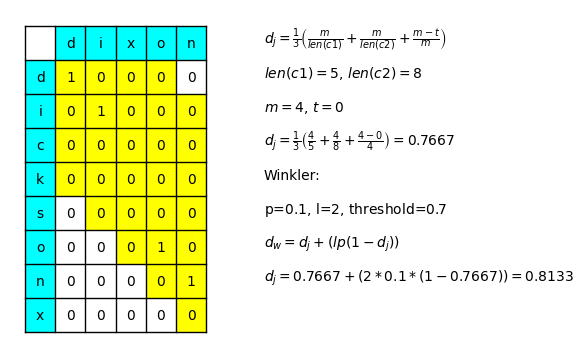

0.8133333333333332

In [20]:
DistanceDeJaroWinkler("dixon", show_table=True)("dicksonx")

In [14]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeJaroWinkler, TestWord, TestWord[:2], mofier_funct=lambda x: 1 - x
)
print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeJaroWinkler.__name__), time_elapsed
    )
)
print("Prediction for word: ", TestWord)
print(pred)

DistanceDeJaroWinkler as mis 0.597260 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
865  aboucherons  0.076364
854     aboucher  0.079545
867     abouches  0.079545


In [15]:
utils.displayComparaisonInterface(
    DistanceDeLevenshtein,
    DistanceDeDamerauLevenshtein,
    DistanceDeJaro,
    DistanceDeJaroWinkler,
)

Text(value='', _dom_classes=('custom-size',))

GridspecLayout(children=(Label(value='Levenshtein', layout=Layout(grid_area='widget001'), _dom_classes=('custo…